### Obtaining event rates

Now I want to create an GW event rate.

From Lynch:

GW event rate = $<V><R>$

"R is LIGO-Virgo’s empirically motivated rate-density estimate and ⟨V⟩ is the average sensitive volume of the epoch’s GW search. We estimate the cosmologically-corrected sensitive volume for each epoch at an SNR threshold of 8, ⟨V8⟩, using the online distance calculator provided by (Chen et al. 2017b), so that the average sensitive volume at a given ρ is given by:"

$<V> = <V_8> \times (\frac{\rho}{8})^{-3}$

Have a poke through Ben Farr's project to see how to go about event rate calculations https://git.ligo.org/post-o5/science-study .

---

From https://arxiv.org/abs/1709.08079

$V_z = \frac{\int_{D_c \lt d^h} \frac{D_c^2}{1+z(D_c)}dD_c d\Omega \sin{\iota} d\iota d\psi}{\sin{\iota}d\iota d\psi}$

$d^h$ is the farthest luminosity distance that the BBH could be detected with an SNR>8 in an optimal orientation. BBH is defined as a $30-30 M_{\odot}$ system (source frame). This is the comoving distance for an SNR at threshold.

$D_c$ is the comoving distance.

$V_z = \frac{4}{3} \pi R^3$ for R the range distance.

Tool for calculating distances: https://github.com/hsinyuc/distancetool

---

Noise curves found here: https://dcc.ligo.org/LIGO-T2000012/public

and post-O5: https://git.ligo.org/post-o5/sensitivity-curves

---

Check GWpopulation code for rate estimation stuff. TUTORIAL.

* To estimate the TAR we can take a set of hyperparameters, say the median of one population model, and assume this to be the true distribution.
    * **STEP 0**: identiofy the normalisation constant that must have been required in making the plots in the GWTC-3 pops paper
    * **STEP ONE**: assume a true model
* The arrival of events follows a Poisson distribution from which we are interested in the rate $\Lambda$.
* When we draw from a population model, we obtain merger rate densities. 
* Taking the distribution of $m_1$ as an example; this is a probability distribution with the vertical axis given in terms of $\frac{d\mathcal{R}}{dm_1}[\text{Gpc}^{-3}\text{yr}^{-1}\text{M}_{\odot}^{-1}]$.
* If we want to be left with a rate then we want to integrate over the co-moving volume and over the masses.
* As per Mandel et al., drawing samples from a distribution for a given parameter and then averaging them is equivalent to integrating that parameter out of the distribution.
* So if we want to be left with a rate in units of yr$^{-1}$ (in the observer frame), we want to draw samples for mass from the distribution and average over these, then draw samples for redshift to integrate out the comoving volume. 
    * **STEP TWO**: sample masses from the model and average over these
    * **STEP THREE**: sample redshifts from the model and average over these
        * the redshift step sounds a little trickier than just that, redshift to comoving volume and average
* In doing this we need to be careful about the sampling procedure and ensure that samples are taken uniformly from the distribution. 
* When we assume a model and use it to obtain samples, we need to divide by the shape (in terms of areas of over and under density) of the model.
* **NORMALISATION** of the model is important, I need to keep track of this or my rate will be determined by the number of samples

/tmp/ipykernel_414100/2000564883.py:173: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


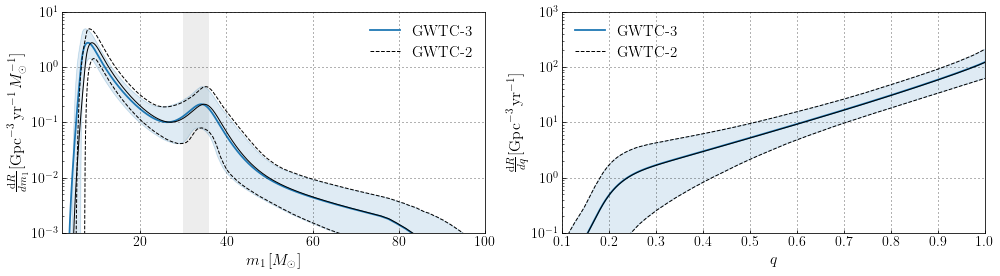

In [1]:

"""
make_plpeak_mass_spectrum.py

Part of the data release: https://zenodo.org/record/5650062

Authors: Bruce Edelman on behalf of the LIGO Scientific Collaboration, Virgo Collaboration and KAGRA Collaboration

This software is provided under license: Creative Commons Attribution 4.0
International (https://creativecommons.org/licenses/by/4.0/legalcode) and  is provided as-is.

This script creates Figure 10 in the companion paper

JH: python make_plpeak_mass_spectrum.py ../analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5 output_name.png

"""
import numpy as np
import matplotlib.pyplot as plt
import mpl_utils
import argparse
import json
import h5py
%matplotlib inline

fig_width = mpl_utils.widths["textwidth"]

# cli_parser = argparse.ArgumentParser()
# cli_parser.add_argument('input_fname')
# cli_parser.add_argument('output_fname')
# cli_args = cli_parser.parse_args()

input_fname = '../GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'

color_plpeak = "#1f78b4"
# O3a_PPD = "o3a_population_data_release/Multiple-Fig-Data/mass_ppd/default/o1o2o3_mass_c_iid_mag_two_comp_iid_tilt_powerlaw_redshift_mass_data.h5"
O3a_PPD = '../GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_mass_data.h5'
O3_only_PPD = input_fname
O3_only_result = O3_only_PPD.replace("_mass_data.h5", "_result.json")

with open(O3_only_result, "r") as jfile:
    plpeak_jf = json.load(jfile)

posterior_samples_plpeak = plpeak_jf["posterior"]["content"]
peak_plp = posterior_samples_plpeak["mpp"]
peak_plp_05 = np.quantile(peak_plp, 0.05)
peak_plp_95 = np.quantile(peak_plp, 0.95)

mass_1 = np.linspace(2, 100, 1000)
mass_ratio = np.linspace(0.1, 1, 500)

fig, axs = plt.subplots(
    nrows=1, ncols=2, figsize=(2 * fig_width, (9.0 / 16) * fig_width)
)

with h5py.File(O3_only_PPD, "r") as f:
    mass_ppd = f["ppd"]
    mass_lines = f["lines"]
    mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
    mass_r_ppd = np.trapz(mass_ppd, mass_1, axis=-1)
    mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
    mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
    mass_r_lower = np.percentile(mass_lines["mass_ratio"], 5, axis=0)
    mass_r_upper = np.percentile(mass_lines["mass_ratio"], 95, axis=0)

ax = axs[0]
ax.plot(
    mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="GWTC-3"
)
ax.plot(mass_1, mass_1_lower, lw=0.2, color=color_plpeak, zorder=1, alpha=0.3)
ax.plot(mass_1, mass_1_upper, lw=0.2, color=color_plpeak, zorder=1, alpha=0.3)
ax.fill_between(
    mass_1,
    mass_1_lower,
    mass_1_upper,
    alpha=0.14,
    color=color_plpeak,
    zorder=0,
)

ax.set_xlim(2.0, 100.0)
ax.set_yscale("log")
ax.set_ylim(1e-3, 10)
ax.grid(True, dashes=(1, 3))
ax.fill_betweenx(
    [1e-5, 1e5],
    peak_plp_05,
    peak_plp_95,
    zorder=-3,
    facecolor="#ebebeb",
    edgecolor="grey",
    alpha=0.9,
    linewidth=0,
)
ax.set_xlabel(r"$m_{1}\,[M_{\odot}]$")
ax.set_ylabel(
    r"$\frac{\mathrm{d}R}{dm_{1}} [\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}\,M_{\odot}^{-1}]$"
)
ax = axs[1]
ax.plot(
    mass_ratio,
    mass_r_ppd,
    lw=1.8,
    color=color_plpeak,
    zorder=1,
    label="GWTC-3",
)
ax.plot(
    mass_ratio, mass_r_lower, lw=0.2, color=color_plpeak, zorder=1, alpha=0.3
)
ax.plot(
    mass_ratio, mass_r_upper, lw=0.2, color=color_plpeak, zorder=1, alpha=0.3
)
ax.fill_between(
    mass_ratio,
    mass_r_lower,
    mass_r_upper,
    alpha=0.14,
    color=color_plpeak,
    zorder=0,
)

ax.set_xlim(0.1, 1)
ax.set_yscale("log")
ax.set_ylim(0.1, 1000)
ax.grid(True, dashes=(1, 3))
ax.set_xlabel(r"$q$")
ax.set_ylabel(
    r"$\frac{\mathrm{d}R}{dq} [\mathrm{Gpc}^{-3}\,\mathrm{yr}^{-1}]$"
)

mass_1 = np.linspace(3, 100, 1000)
with h5py.File(O3a_PPD, "r") as f:
    mass_ppd = f["ppd"]
    mass_lines = f["lines"]

    # Integrate the 2D PPD over mass ratio to get marginal m1 PPD
    mass_1_ppd = np.trapz(mass_ppd, mass_ratio, axis=0)
    mass_r_ppd = np.trapz(mass_ppd, mass_1, axis=-1)

    # Get 0.05 and 0.95 percentiles at each m1
    mass_1_lower = np.percentile(mass_lines["mass_1"], 5, axis=0)
    mass_1_upper = np.percentile(mass_lines["mass_1"], 95, axis=0)
    mass_r_lower = np.percentile(mass_lines["mass_ratio"], 5, axis=0)
    mass_r_upper = np.percentile(mass_lines["mass_ratio"], 95, axis=0)

ax = axs[0]
ax.plot(
    mass_1,
    mass_1_lower,
    lw=1,
    ls="--",
    color="k",
    zorder=1,
    alpha=1,
    label="GWTC-2",
)
ax.plot(mass_1, mass_1_upper, lw=1, ls="--", color="k", zorder=1, alpha=1)
ax.plot(mass_1, mass_1_ppd, lw=1, color="k", zorder=1, alpha=1)
ax.legend(frameon=False)
ax = axs[1]
ax.plot(
    mass_ratio,
    mass_r_lower,
    lw=1,
    ls="--",
    color="k",
    zorder=1,
    alpha=1,
    label="GWTC-2",
)
ax.plot(mass_ratio, mass_r_upper, lw=1, ls="--", color="k", zorder=1, alpha=1)
ax.plot(mass_ratio, mass_r_ppd, lw=1, color="k", zorder=1, alpha=1)
ax.legend(frameon=False)
plt.tight_layout()
plt.savefig('plpeak_mass_spectrum.png')


got a powerlaw peak form, so can numerically integrate. scipy.quad int from min to max, 

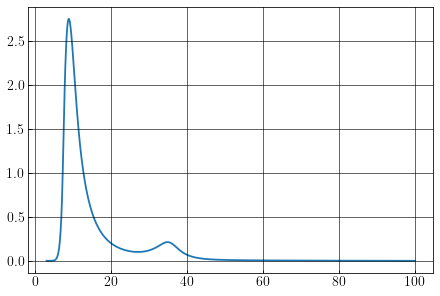

In [7]:
plt.plot(mass_1, mass_1_ppd, lw=1.8, color=color_plpeak, zorder=1, label="GWTC-3")

In [31]:
# interpolate the mass model using the same mass ranges as above to create a function for scipy.integrate.quad to integrate
from scipy.interpolate import interp1d as interp1d
mass_model_interp = interp1d(mass_1, mass_1_ppd)

# input the function and the upper and lower bounds into scipy.quad to integrate
from scipy.integrate import quad as quad
mmin = min(mass_1)
mmax = max(mass_1)
rate_V = quad(mass_model_interp, mmin, mmax)
print(rate_V)

(17.762578620977788, 0.0008260690078627683)


/tmp/ipykernel_414100/4117920885.py:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rate_V = quad(mass_model_interp, mmin, mmax)


So over this mass range the average rate is $R = 17.76 [\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}]$, this is also the rate using the mass_ratio distribution.
* so this numerically integrated with an approximate function from interp1d, rather than a function defined by the powerlaws
* I also haven't considered the normalisation
* look up the difference between quad and trapz
    * quad is not used in high dimensional integration as you need $n^p$ grid points for $p$ dimensions - curse of dimensionality
* plugging in the mass_1_lower and mass_1_upper distributions give rates of 8.46 and 32.3 respectively
* **this is an average rate over the whole mass range, $P_\mathrm{astro}$ is for each event**
    * so integrate out the volume first and then just plug the event masses into the expression?
        * this would ignore the spins...

From the GWTC-3 populations paper, https://arxiv.org/abs/2111.03634:
* Accounting for the BBH merger rate to evolve with redshift, we find the BBH merger rate to be between 17.9 Gpc−3 yr−1 and 44 Gpc−3 yr−1 at a fiducial redshift (z = 0.2).
    * what do they mean by "at a fiducial redshift (z = 0.2)"

In [79]:
# test the result with the mass_ratio distribution, these should be the same since they are just marginalised versions of the same 2D PPD
# integrate mass_ratio distributions at the same time with scipy.integrate.quad
from scipy.interpolate import interp1d as interp1d
q_model_interp = interp1d(mass_ratio, mass_r_ppd)

# input the function and the upper and lower bounds into scipy.quad to integrate
from scipy.integrate import quad as quad
qmin = min(mass_ratio)
qmax = max(mass_ratio)
rate_V_q = quad(q_model_interp, qmin, qmax)
print(rate_V_q)

(17.762991620646854, 1.8139726180453955e-05)


/tmp/ipykernel_414100/1438238815.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  rate_V_q = quad(q_model_interp, qmin, qmax)


I want to check this with and MCMC approach and see if I get the same result.

Lecture on sampling with MCMC, Gibbs, Hastings: https://people.duke.edu/~ccc14/sta-663/mcmc.html

   1000000 17.815678


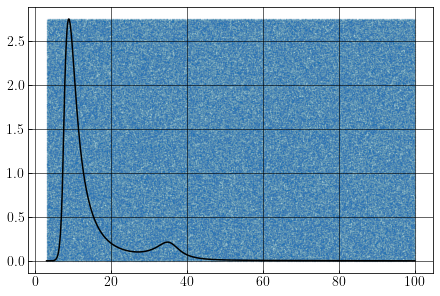

In [71]:
# approximate the integral with monte carlo integration
n=1000000
x = np.linspace(mmin, mmax, n)
plt.plot(x, mass_model_interp(x), color='black');
xpts = np.random.uniform(mmin,mmax,(n, 1))
ypts = np.random.uniform(min(mass_model_interp(xpts)),max(mass_model_interp(xpts)),(n, 1))
# pts = np.array(xpts, ypts)
plt.scatter(xpts, ypts, s=0.1, alpha=0.1)

count = np.sum(ypts < mass_model_interp(xpts))
volume = max(ypts-min(ypts))*(mmax-mmin) # volume of region
sol = (volume * count)/n
print('%10d %.6f' % (n, sol))

Using this method I get an average rate of $R = 17.82 [\mathrm{Gpc}^{-3}\mathrm{yr}^{-1}]$ for $10^6$ points.

In [40]:
import emcee

def log_prob(m):
    return np.log(mass_model_interp(m))

ndim, nwalkers = 1, 100
p0 = np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[mass_1])
sampler.run_mcmc(p0, 10000)

emcee: Exception while calling your likelihood function:
  params: [0.71353631]
  args: [array([  3.        ,   3.0970971 ,   3.19419419,   3.29129129,
         3.38838839,   3.48548549,   3.58258258,   3.67967968,
         3.77677678,   3.87387387,   3.97097097,   4.06806807,
         4.16516517,   4.26226226,   4.35935936,   4.45645646,
         4.55355355,   4.65065065,   4.74774775,   4.84484484,
         4.94194194,   5.03903904,   5.13613614,   5.23323323,
         5.33033033,   5.42742743,   5.52452452,   5.62162162,
         5.71871872,   5.81581582,   5.91291291,   6.01001001,
         6.10710711,   6.2042042 ,   6.3013013 ,   6.3983984 ,
         6.4954955 ,   6.59259259,   6.68968969,   6.78678679,
         6.88388388,   6.98098098,   7.07807808,   7.17517518,
         7.27227227,   7.36936937,   7.46646647,   7.56356356,
         7.66066066,   7.75775776,   7.85485485,   7.95195195,
         8.04904905,   8.14614615,   8.24324324,   8.34034034,
         8.43743744,   8.5345

Traceback (most recent call last):
  File "/data/wiay/johnny/phd1/envs/igwn/lib/python3.9/site-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
TypeError: log_prob() takes 1 positional argument but 2 were given


TypeError: log_prob() takes 1 positional argument but 2 were given

In [39]:
p0.shape

(100, 5)

182.94046957459844
14.8001835140235


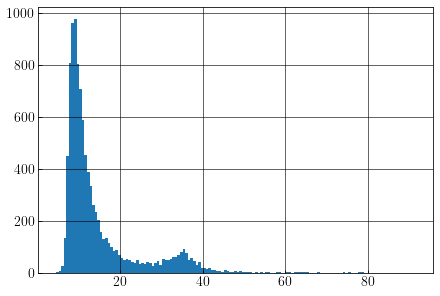

In [12]:
# generate some random number between 0 and 1
uniform_vals = np.random.uniform(0,1,10000)

# create cdf
# units of per mass
PP_mass_cdf = np.cumsum(mass_1_ppd)
print(PP_mass_cdf[-1])
PP_mass_cdf = (PP_mass_cdf - PP_mass_cdf[0])
PP_mass_cdf /= PP_mass_cdf[-1]

# interpolate to create a function that maps from the y axis of the cdf to the corresponding x value and feed this the uniform_vals
mass_samp = np.interp(uniform_vals, PP_mass_cdf, mass_1)

# plot the samples
plt.hist(mass_samp, bins='auto')

# average of samples
av_mass_samp = np.average(mass_samp)
print(av_mass_samp)

Here I set the mass model to SinglePeakSmoothedMassDistribution with input parameters defined as the median of those in the posteriors from ../GWTC-3-population-data/analyses/PowerLawPeak/o1o2o3_mass_c_iid_mag_iid_tilt_powerlaw_redshift_result.json

If I am going to numerically integrate then I need an actual function, rather than an interpolated function.

If using the interpolated function then I could MCMC.

In [25]:
# read in the hyperposterior results
from bilby.core.result import read_in_result
PP_result = read_in_result(O3_only_result)
PP_hyperposterior_samples = PP_result.posterior.copy()

# write a function for the distribution, or import from gwpopulation
# fit the function parameters to the curve above, or just select some median
import gwpopulation as gwpop
mmin = np.median(PP_hyperposterior_samples['mmin'])
mmax = np.median(PP_hyperposterior_samples['mmax'])
alpha = np.median(PP_hyperposterior_samples['alpha'])
beta = np.median(PP_hyperposterior_samples['beta'])
lam = np.median(PP_hyperposterior_samples['lam'])
mpp = np.median(PP_hyperposterior_samples['mpp'])
sigpp = np.median(PP_hyperposterior_samples['sigpp'])
delta_m = np.median(PP_hyperposterior_samples['delta_m'])
mass_model = gwpop.models.mass.SinglePeakSmoothedMassDistribution(mmin = min(mass_1), mmax = max(mass_1))
import pandas as pd
input_df = pd.DataFrame(mass_1, columns = ['mass_1'])



/tmp/ipykernel_414100/2740020251.py:27: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  rate_V = quad(mass_model_interp, mmin, mmax)


In [26]:
rate_V

(17.758140219358346, 0.0019705825700728225)

In [ ]:
from scipy.integrate import quad as quad
